<a href="https://colab.research.google.com/github/ANadalCardenas/attention/blob/main/lab_contrastive_todo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Contrastive Learning using SimCLR

Created by [Àlex Solé](https://www.linkedin.com/in/alex-sole-gomez/) for the [Postgraduate course in artificial intelligence with deep learning](https://www.talent.upc.edu/ing/estudis/formacio/curs/310400/postgrau-artificial-intelligence-deep-learning/) in [UPC School](https://www.talent.upc.edu/ing/) (2025).


# Contrastive Learning with SimCLR on STL10 Dataset

In this lab, we will implement and explore Self-Supervised Learning through Contrastive Learning using the SimCLR (Simple Framework for Contrastive Learning of Visual Representations) approach.

## What is SimCLR?

[SimCLR](https://arxiv.org/abs/2002.05709) is a simple framework for contrastive learning of visual representations developed by Google Research. It learns representations by maximizing agreement between differently augmented views of the same data example while minimizing agreement between augmented views of different examples.

<p align="center"><br>
<img src="https://github.com/telecombcn-dl/labs-all/raw/main/labs/contrastive_learning/images/simclr_architecture.png" class="center" title="SimCLR" width="400"/>
</p><br>

## Our Dataset: STL10

We'll be using the [STL10](https://cs.stanford.edu/~acoates/stl10/) dataset, which is specifically designed for unsupervised learning:
- 100,000 unlabeled images for training
- 5,000 labeled training images and 8,000 test images
- 10 classes (airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck)
- 96x96 pixel resolution color images
- Designed for developing unsupervised feature learning, deep learning, and self-taught learning algorithms

The dataset has two main splits:
1. **Unlabeled split**: 100,000 images without labels for self-supervised pretraining
2. **Labeled split**: A smaller set of labeled images (5,000 training, 8,000 testing) for supervised fine-tuning and evaluation

<p align="center"><br>
<img src="https://github.com/telecombcn-dl/labs-all/raw/main/labs/contrastive_learning/images/STL10_dataset.png?raw=true" class="center" title="STL-10" width="400"/>
</p><br>

## Approach

We will:
1. Create data augmentation pipelines
2. Implement a ResNet-based encoder network
3. Build a projection head for the contrastive learning task
4. Train the model using the contrastive loss function
5. Evaluate the learned representations on downstream tasks

Let's explore how we can learn meaningful representations without relying on labeled data!

In [1]:
import torch
import torchvision.models as models
import numpy as np
import os
import torch
import torchvision.transforms as T
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import STL10
from torch.utils.data import DataLoader
from torch.multiprocessing import cpu_count
import torchvision.transforms as T

To ensure reproducibility of the experiments, we can set the seed to a fixed number.

In [2]:
SEED = 77777
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)
torch.cuda.manual_seed(SEED)

In [3]:
if not torch.cuda.is_available():
    raise RuntimeError("GPU not available. Please run change your runtime type and select GPU.")
DEVICE = torch.device("cuda")

# The SimCLR Method: Contrastive Learning

SimCLR learns representations by contrasting positive pairs against negative pairs in a latent space. Let's break down how this works:

## Contrastive Loss Function

Let $\text{sim}(u,v)$ denote the dot product between two normalized vectors $u$ and $v$ (i.e., cosine similarity).

The loss function for a positive pair of examples $(i,j)$ is defined as:

$$\ell_{i,j} = -\log \frac{\exp(\text{sim}(z_i, z_j)/\tau)}{\sum_{k=1}^{2N} \mathbf{1}_{[k \neq i]} \exp(\text{sim}(z_i, z_k)/\tau)}$$

Where:
- $\mathbf{1}_{[k \neq i]} \in \{0, 1\}$ is an indicator function evaluating to 1 if and only if $k \neq i$
- $\tau$ is a temperature parameter that controls the concentration level of the distribution
- $z_i$ and $z_j$ are the projected representations of two augmented views of the same image

## Key Components

1. **Positive pairs**: Different augmentations of the same image
2. **Negative pairs**: Augmentations of different images
3. **Temperature scaling**: Lower values of $\tau$ make the model more sensitive to hard negative examples

The final loss is computed by summing over all positive pairs and dividing by $2 \times N = \text{views} \times \text{batch\_size}$, where in SimCLR we typically have 2 views per image.

This approach encourages the model to pull representations of the same image closer together while pushing representations of different images apart in the embedding space.

**Note:**

# Implement the ContrastiveLoss in Pytorch

## Similarity Matrix Calculation

First, we need to implement the similarity matrix between all images in the batch by calculating the cosine similarity between all projections.

Complete the `calc_similarity_batch` function using PyTorch's [Cosine Similarity](https://pytorch.org/docs/stable/generated/torch.nn.functional.cosine_similarity.html) function.


### Implementing Similarity Matrix Using Broadcasting

1. We first combine the vectors from both views (`a` and `b`) into a single tensor of shape `[2*batch_size, embedding_dim]`
2. Using `unsqueeze()`, we create two tensors:
    - `representations.unsqueeze(1)` has shape `[2*batch_size, 1, embedding_dim]`
    - `representations.unsqueeze(0)` has shape `[1, 2*batch_size, embedding_dim]`
3. When we compute cosine similarity between these tensors, PyTorch automatically broadcasts them to match dimensions:
    - The first tensor is expanded along dimension 1 to `[2*batch_size, 2*batch_size, embedding_dim]`
    - The second tensor is expanded along dimension 0 to `[2*batch_size, 2*batch_size, embedding_dim]`
4. The resulting similarity matrix has dimensions `[2*batch_size, 2*batch_size]`, where each entry `(i,j)` represents the cosine similarity between vector `i` and vector `j`

This approach is much more efficient than iterating through all pairs of vectors and computing similarities individually.

In [5]:
def calc_similarity_batch(a, b):
    #TODO: concat the representations
    representations = torch.cat([a, b], dim=0)

    #TODO: calculate the cosine similarity
    similarity_matrix = F.cosine_similarity(representations.unsqueeze(1), representations.unsqueeze(0), dim=2)

    return similarity_matrix

Let's run a dummy test to make sure that the output shape is correct. We'll create random embeddings and verify that our function returns a matrix with the expected dimensions.

In [6]:
# Test calc_similarity_batch function
batch_size = 4  # Small batch size for testing
embedding_dim = 128  # Typical embedding dimension

# Create random embeddings
a = torch.randn(batch_size, embedding_dim)
b = torch.randn(batch_size, embedding_dim)

# Calculate similarity matrix
similarity_matrix = calc_similarity_batch(a, b)


# Verify the shape is (2*batch_size, 2*batch_size)
expected_shape = (2 * batch_size, 2 * batch_size)
assert similarity_matrix.shape == expected_shape, f"Similarity matrix has shape {similarity_matrix.shape} but expected {expected_shape}"
print("calc_similarity_batch function outputs the expected shape.")



calc_similarity_batch function outputs the expected shape.


### Understanding the `torch.diag()` Function

Before continuing to the next section, we need to understand what [`torch.diag()`](https://pytorch.org/docs/stable/generated/torch.diag.html) does. This function serves two purposes in PyTorch:

1. When given a 2D tensor (matrix), it extracts the diagonal elements
2. When given a 1D tensor (vector), it creates a diagonal matrix with the vector elements on the diagonal

The diagonal parameter indicates which diagonal to extract:
- `diagonal = 0`: Extracts the main diagonal
- `diagonal > 0`: Extracts the diagonal above the main diagonal (by offset positions)
- `diagonal < 0`: Extracts the diagonal below the main diagonal (by offset positions)

In [7]:
# Let's create a random matrix
a = torch.randn(3, 3)
a

tensor([[ 0.0106,  1.0878, -0.1459],
        [ 1.1485, -0.9193,  0.7493],
        [ 0.2187,  0.8486, -0.6550]])

In [8]:
torch.diag(a, 0)  # Extract the diagonal elements

tensor([ 0.0106, -0.9193, -0.6550])

In [9]:
torch.diag(a, 1)  # Extract the diagonal elements above the main diagonal

tensor([1.0878, 0.7493])

# Defining the Contrastive Loss class

- First we need to normalize the output embeddings from our convolutional backbone. Normalizing embeddings ensures all representations lie on the unit hypersphere, preventing the model from artificially increasing distances between samples rather than learning meaningful representations.

- Next, we calculate the similarity matrix using the `calc_similarity_batch` function we implemented.

- Then we need to identify positive pairs within the similarity matrix. In the sample image we have the similarity matrix for a `batch_size=2`, and we can see that the positives images are offset by `2` and `-2` with respect to the diagonal. These positive pairs are always shifted from the main diagonal by the batch size. If we want to make it more generic, we can access them using `torch.diag()` with a diagonal at `batch_size` and another diagonal at `-batch_size`.

<p align="center"><br>
<img src="https://github.com/telecombcn-dl/labs-all/raw/main/labs/contrastive_learning/images/sim_matrix.png" class="center" title="Sim_matrix" width="600"/>
</p><br>

- With all these components, we can calculate the contrastive loss function following the equation:

$$\ell_{i,j} = -\log \frac{\exp(\text{sim}(z_i, z_j)/\tau)}{\sum_{k=1}^{2N} \mathbf{1}_{[k \neq i]} \exp(\text{sim}(z_i, z_k)/\tau)}$$

Where:
- $\mathbf{1}_{[k \neq i]}$ is the mask that excludes the current sample from the denominator (implemented as `self.mask` in our class)
- $\tau$ is the temperature parameter that controls how concentrated the distribution becomes
- $z_i$ and $z_j$ are the projected representations of two augmented views of the same image


**hint**: Use [`torch.exp()`](https://pytorch.org/docs/stable/generated/torch.exp.html) and [`torch.log()`](https://pytorch.org/docs/stable/generated/torch.log.html)

In [10]:
class ContrastiveLoss(nn.Module):
    """
    Vanilla Contrastive loss, also called InfoNceLoss as in SimCLR paper
    """
    def __init__(self, batch_size, temperature=0.5):
        super().__init__()
        self.batch_size = batch_size
        self.temperature = temperature
        self.mask = (~torch.eye(batch_size * 2, batch_size * 2, dtype=bool)).float()



    def forward(self, proj_1, proj_2):
        """
        proj_1 and proj_2 are batched embeddings [batch, embedding_dim]
        where corresponding indices are pairs
        z_i, z_j in the SimCLR paper
        """
        batch_size = proj_1.shape[0]
        #TODO: normalize the projections
        z_i = F.normalize(proj_1, p=2, dim=1)
        z_j = F.normalize(proj_2, p=2, dim=1)

        #TODO: calculate the similarity matrix
        similarity_matrix = calc_similarity_batch(z_i, z_j)

        #TODO: calculate the positive pairs
        sim_ij = torch.diag(similarity_matrix, self.batch_size)
        sim_ji = torch.diag(similarity_matrix, -self.batch_size)

        positives = torch.cat([sim_ij, sim_ji], dim=0)

        # Apply temperature
        similarity_matrix = similarity_matrix / self.temperature

        # Apply mask to remove self-similarities from the denominator
        exp_similarity_matrix = torch.exp(similarity_matrix) * self.mask.to(similarity_matrix.device)

        #TODO: calculate the nominator
        nominator = torch.exp(positives / self.temperature)

        #TODO: calculate the denominator
        denominator = torch.sum(exp_similarity_matrix, dim=1)

        #TODO: calculate the loss
        all_losses = -torch.log(nominator / denominator)

        #Normalize the loss
        loss = torch.sum(all_losses) / (2 * self.batch_size)
        return loss

# Data augmentation

For the SimCLR pipeline, we need specific data augmentations to create different views of the same image. The Augment class below implements these key transformations:

1. **Random cropping**: Crops random portions of images at different scales
2. **Random color distortions**: Applies color jitter with randomized brightness, contrast, saturation, and hue
3. **Random Gaussian blur**: Applies blur with varying intensity
4. **Random grayscale conversion**: Occasionally converts images to grayscale

These augmentations are critical for SimCLR as they create semantically similar but visually different views of the same image. When applied to a single image, they produce two different views that maintain the same semantic content but with different visual appearances - these become our positive pairs.


In [11]:
class Augment:
    """
    A stochastic data augmentation module
    Transforms any given data example randomly
    resulting in two correlated views of the same example,
    denoted x ̃i and x ̃j, which we consider as a positive pair.
    """

    def __init__(self, img_size, s=1):
        color_jitter = T.ColorJitter(
            0.8 * s, 0.8 * s, 0.8 * s, 0.2 * s
        )

        self.train_transform = T.Compose(
            [
            T.RandomResizedCrop(size=img_size),
            T.RandomHorizontalFlip(p=0.5),  # with 0.5 probability
            T.RandomApply([color_jitter], p=0.8),
            T.RandomGrayscale(p=0.2),
            # imagenet stats
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ]
        )

        self.test_transform = T.Compose(
            [
                T.ToTensor(),
                T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ]
        )

    def __call__(self, x):
        return self.train_transform(x), self.train_transform(x)

In [12]:
import matplotlib.pyplot as plt

def imshow(img):
    """
    shows an imagenet-normalized image on the screen
    """
    mean = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float32)
    std = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32)
    unnormalize = T.Normalize((-mean / std).tolist(), (1.0 / std).tolist())
    npimg = unnormalize(img).numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Visualize some of the images

100%|██████████| 2.64G/2.64G [00:48<00:00, 54.9MB/s]


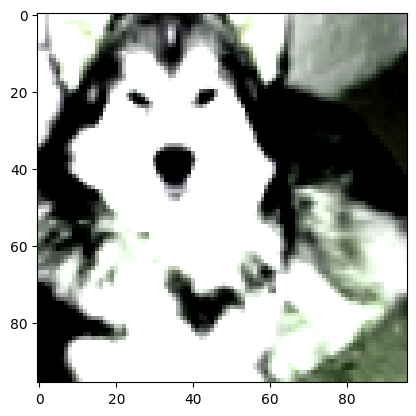

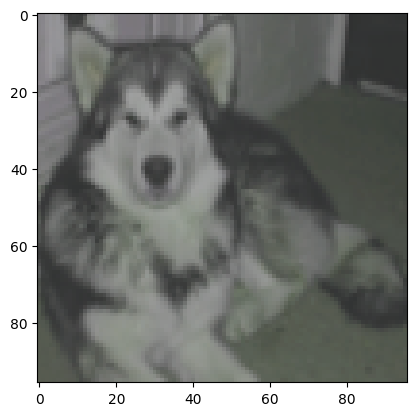

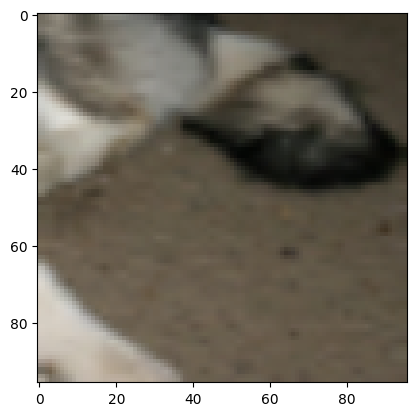

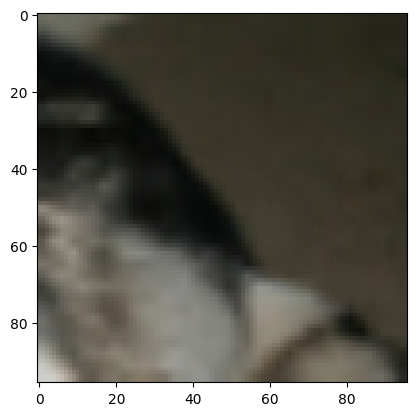

In [13]:
# This can take a while sometimes, you can just continue the lab while it downloads
dataset = STL10("./", split='train', transform=Augment(96), download=True)
imshow(dataset[99][0][0])
imshow(dataset[99][0][0])
imshow(dataset[99][0][0])
imshow(dataset[99][0][0])

# Define the model

We will use the Resnet18 and we will modify the head to output embeddings instead of class probabilities.

In [14]:
class SimCLR_ResNet(nn.Module):
    def __init__(self, pretrained=False, out_dim=128):
        super(SimCLR_ResNet, self).__init__()
        self.base_model = models.resnet18(pretrained=pretrained)
        #TODO: override the last layer of the base model
        self.base_model.fc = nn.Sequential(
            #Linear layer of 512,512
            nn.Linear(self.base_model.fc.in_features, 512),
            #BatchNorm layer of 512
            nn.BatchNorm1d(512),
            #ReLU activation
            nn.ReLU(),
            #Linear layer of 512,out_dim
            nn.Linear(512, out_dim),
            #BatchNorm layer of out_dim
            nn.BatchNorm1d(out_dim)
        )

    def forward(self, x):
        x = self.base_model(x)
        return x

# SimCLR Training Process Explained

SimCLR performs self-supervised learning by creating two different augmented views of each image and training the network to recognize them as similar, while distinguishing them from other images.

<p align="center"><br>
<img src="https://media0.giphy.com/media/v1.Y2lkPTc5MGI3NjExNG90NGd1YWVlbGJwaHJiaTJoZ2M5MTM5czY3aWRueTNpYnRpZ2V6ZyZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/8SZhj0qY3XlHcr1150/giphy.gif" class="center" width="400"/>
</p><br>


SimCLR training involves several key steps:

1. **Views creation**: For each batch of images, we create two augmented views of each image.

2. **Forward Pass**: Both augmented views pass through the encoder network and projection head to extract embeddings.

3. **Contrastive Loss Calculation**: The embeddings are used to compute the contrastive loss:
    - Positive pairs (different views of same image) should have similar embeddings
    - Negative pairs (views from different images) should have dissimilar embeddings

4. **Optimization**: The network parameters are updated through backpropagation to minimize this contrastive loss.

5. **Downstream Evaluation**: After training, the encoder (without the projection head) can be used for downstream tasks like classification.

The temperature parameter τ controls the concentration level of the positive/negative sample distribution, affecting how hard the model considers negative examples.

In [15]:
from tqdm import tqdm

def train_simclr(model, train_loader, optimizer, criterion, epochs, device, log_interval=10):
    """
    Train the SimCLR model

    Args:
        model: The SimCLR model
        train_loader: DataLoader for training data
        optimizer: Optimizer for training
        criterion: Contrastive loss function
        epochs: Number of epochs to train for
        device: Device to train on
        log_interval: How often to log progress

    Returns:
        List of training losses
    """
    model.train()
    losses = []

    for epoch in tqdm(range(epochs)):
        running_loss = 0.0
        epoch_pbar = tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}")

        for batch_idx, ((x_i, x_j), _) in enumerate(train_loader):
            # Move data to device
            x_i, x_j = x_i.to(device), x_j.to(device)

            # TODO: Forward pass through the model
            z_i = model(x_i)
            z_j = model(x_j)

            # TODO: Calculate contrastive loss
            loss = criterion(z_i, z_j)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update running loss
            running_loss += loss.item()

            # Update progress bar
            epoch_pbar.set_postfix({"batch_loss": f"{loss.item():.6f}"})
            epoch_pbar.update(1)

            # Log progress to console
            if batch_idx % log_interval == 0 and batch_idx > 0:
                print(f'Epoch: {epoch+1}/{epochs}, Batch: {batch_idx}/{len(train_loader)}, '
                      f'Loss: {loss.item():.6f}')

        # Calculate average loss for epoch
        epoch_loss = running_loss / len(train_loader)
        losses.append(epoch_loss)

        # Close progress bar
        epoch_pbar.close()

        print(f'Epoch: {epoch+1}/{epochs}, Average Loss: {epoch_loss:.6f}')

    return losses

Let's train our SimCLR model for a single epoch on the unlabeled split of STL10 to verify our implementation works correctly.

In [16]:
# Prepare the STL10 dataset with unlabeled data for SimCLR pretraining
batch_size = 256  # Larger batch size for contrastive learning
unlabeled_dataset = STL10(root="./", split='unlabeled', transform=Augment(96), download=True)

unlabeled_dataset = torch.utils.data.Subset(unlabeled_dataset, list(range(1000)))  # Use a subset for faster training
train_loader = DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True, num_workers=cpu_count())

# Define the model
model = SimCLR_ResNet(pretrained=False, out_dim=128).to(DEVICE)

# Define optimizer (Adam with weight decay as in SimCLR paper)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-6)

# Define contrastive loss
criterion = ContrastiveLoss(batch_size=batch_size, temperature=0.5).to(DEVICE)

# Training parameters
num_epochs = 1  # Reduced for demonstration, SimCLR typically uses 100+ epochs

# Train the model
loss_history = train_simclr(model, train_loader, optimizer, criterion, num_epochs, DEVICE, log_interval=100)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
100%|██████████| 1/1 [00:04<00:00,  4.78s/it]

Epoch: 1/1, Average Loss: 6.218162


# Evaluate SimCLR performance

Training a SimCLR model from scratch requires significant computational resources and time. With standard Colab resources, we would reach the time limit before finishing the training.

To work around this limitation, we'll use a practical approach:

1. We've already trained a SimCLR model on the unlabeled split of STL10 for 300 epochs.
2. We'll load these pre-trained weights and evaluate their effectiveness on the labeled split of the STL10 dataset.
3. For comparison, we'll also evaluate:
    - A randomly initialized model (no pre-training)
    - An ImageNet pre-trained model

This approach allows us to understand the benefits of contrastive learning without requiring the extensive training time. The evaluation on the labeled split of STL10 will show us how well the representations learned through self-supervised contrastive learning transfer to supervised classification tasks compared to both random initialization and supervised pre-training on ImageNet.

First we will create the training loop for the supervised split

In [17]:
import numpy as np

def train_evaluation(model, train_loader, test_loader, epochs=50, lr=0.001, device='cuda'):

    # Create optimizer and loss function
    optimizer = torch.optim.SGD(model.base_model.parameters(), lr=lr)
    criterion = nn.NLLLoss()

    best_acc = 0.0

    for epoch in tqdm(range(epochs)):
        # Training
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward pass
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        train_accuracy = 100.0 * correct / total

        # Evaluation
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, targets)

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        test_accuracy = 100.0 * correct / total

        # Save best accuracy
        if test_accuracy > best_acc:
            best_acc = test_accuracy

        # Print progress
        if epoch % 5 == 0 or epoch == epochs - 1:
            print(f'\n Epoch: {epoch+1}/{epochs}, '
                  f'Train Loss: {train_loss/len(train_loader):.4f}, '
                  f'Train Acc: {train_accuracy:.2f}%, '
                  f'Test Loss: {test_loss/len(test_loader):.4f}, '
                  f'Test Acc: {test_accuracy:.2f}%')

    print(f'Best Test Accuracy: {best_acc:.2f}%')
    return best_acc

Now we will create an evaluation model for the supervised classification task on STL10. This model will be used to assess how well our self-supervised representation learning transfers to a downstream classification task.

In [18]:
class SimCLR_ResNet_eval(nn.Module):
    def __init__(self, pretrained=False, out_dim=128):
        super(SimCLR_ResNet_eval, self).__init__()
        self.base_model = models.resnet18(pretrained=pretrained)
        #TODO: override the last layer of the base model
        self.base_model.fc = nn.Sequential(
            #Linear layer of 512,out_dim
            nn.Linear(self.base_model.fc.in_features, out_dim),
            #LogSoftmax layer
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = self.base_model(x)
        return x

Download the pretrained weights

In [19]:
import requests
import os

# URL of the weights file
url = "https://github.com/telecombcn-dl/labs-all/raw/main/labs/contrastive_learning/simclr_stl10_resnet18.pth"

# Create a local path to save the weights
weights_path = "./simclr_stl10_resnet18.pth"

# Download the weights file if it doesn't exist already
if not os.path.exists(weights_path):
    print(f"Downloading weights from {url}...")
    response = requests.get(url)

    if response.status_code == 200:
        with open(weights_path, "wb") as f:
            f.write(response.content)
        print(f"Successfully downloaded weights to {weights_path}")
    else:
        print(f"Failed to download weights: HTTP status code {response.status_code}")
else:
    print(f"Weights file already exists at {weights_path}")

Successfully downloaded weights to ./simclr_stl10_resnet18.pth


Next, we will declare the labeled splits of STL10 and and we will train our model using the pretrained SimCLR weights.

In [20]:
transform_preprocess = Augment(96).test_transform

# Create datasets
train_dataset = STL10(root="./", split='train', transform=transform_preprocess, download=True)
train_dataset = torch.utils.data.Subset(train_dataset, list(range(500))) # Use a subset for faster training
test_dataset = STL10(root="./", split='test', transform=transform_preprocess, download=True)
test_dataset = torch.utils.data.Subset(test_dataset, list(range(500))) # Use a subset for faster training

batch_size=64
# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=cpu_count())
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=cpu_count())


# Create a new model without projection head for evaluation (or modify existing model)
eval_model = SimCLR_ResNet_eval(pretrained=False, out_dim=10).to(DEVICE)

# Load weights from pretrained model (excluding projection head)
# Load the pretrained SimCLR weights
pretrained_weights = torch.load('./simclr_stl10_resnet18.pth', map_location=DEVICE)


# Remove the 'fc' layer from the state_dict
pretrained_weights_no_fc = {k: v for k, v in pretrained_weights["model_state_dict"].items() if not k.startswith('base_model.fc.')}

eval_model.load_state_dict(pretrained_weights_no_fc, strict=False)


simclr_pretrained = train_evaluation(eval_model, train_loader, test_loader, epochs=100, device=DEVICE)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
  1%|          | 1/100 [00:01<02:15,  1.36s/it]


 Epoch: 1/100, Train Loss: 2.3298, Train Acc: 15.40%, Test Loss: 2.2920, Test Acc: 20.00%


  6%|▌         | 6/100 [00:07<02:00,  1.29s/it]


 Epoch: 6/100, Train Loss: 2.1678, Train Acc: 28.80%, Test Loss: 2.1545, Test Acc: 30.20%


 11%|█         | 11/100 [00:12<01:37,  1.09s/it]


 Epoch: 11/100, Train Loss: 2.0279, Train Acc: 41.80%, Test Loss: 2.0359, Test Acc: 37.80%


 16%|█▌        | 16/100 [00:18<01:32,  1.10s/it]


 Epoch: 16/100, Train Loss: 1.9090, Train Acc: 50.00%, Test Loss: 1.9294, Test Acc: 43.00%


 21%|██        | 21/100 [00:23<01:27,  1.11s/it]


 Epoch: 21/100, Train Loss: 1.8006, Train Acc: 57.60%, Test Loss: 1.8335, Test Acc: 49.60%


 26%|██▌       | 26/100 [00:29<01:19,  1.07s/it]


 Epoch: 26/100, Train Loss: 1.6992, Train Acc: 62.60%, Test Loss: 1.7492, Test Acc: 53.00%


 31%|███       | 31/100 [00:35<01:17,  1.13s/it]


 Epoch: 31/100, Train Loss: 1.6224, Train Acc: 64.40%, Test Loss: 1.6657, Test Acc: 58.00%


 36%|███▌      | 36/100 [00:40<01:08,  1.07s/it]


 Epoch: 36/100, Train Loss: 1.5330, Train Acc: 68.80%, Test Loss: 1.5999, Test Acc: 58.60%


 41%|████      | 41/100 [00:46<01:10,  1.19s/it]


 Epoch: 41/100, Train Loss: 1.4676, Train Acc: 69.40%, Test Loss: 1.5343, Test Acc: 60.60%


 46%|████▌     | 46/100 [00:51<00:58,  1.08s/it]


 Epoch: 46/100, Train Loss: 1.3907, Train Acc: 70.40%, Test Loss: 1.4797, Test Acc: 61.80%


 51%|█████     | 51/100 [00:57<01:02,  1.27s/it]


 Epoch: 51/100, Train Loss: 1.3353, Train Acc: 70.80%, Test Loss: 1.4299, Test Acc: 62.00%


 56%|█████▌    | 56/100 [01:03<00:48,  1.11s/it]


 Epoch: 56/100, Train Loss: 1.2799, Train Acc: 71.80%, Test Loss: 1.3810, Test Acc: 62.80%


 61%|██████    | 61/100 [01:08<00:45,  1.16s/it]


 Epoch: 61/100, Train Loss: 1.2421, Train Acc: 71.40%, Test Loss: 1.3343, Test Acc: 64.00%


 66%|██████▌   | 66/100 [01:14<00:37,  1.10s/it]


 Epoch: 66/100, Train Loss: 1.1873, Train Acc: 73.20%, Test Loss: 1.3004, Test Acc: 63.60%


 71%|███████   | 71/100 [01:20<00:33,  1.14s/it]


 Epoch: 71/100, Train Loss: 1.1507, Train Acc: 73.80%, Test Loss: 1.2655, Test Acc: 64.60%


 76%|███████▌  | 76/100 [01:26<00:27,  1.14s/it]


 Epoch: 76/100, Train Loss: 1.1064, Train Acc: 75.20%, Test Loss: 1.2354, Test Acc: 66.00%


 81%|████████  | 81/100 [01:32<00:22,  1.20s/it]


 Epoch: 81/100, Train Loss: 1.0716, Train Acc: 74.00%, Test Loss: 1.2024, Test Acc: 66.40%


 86%|████████▌ | 86/100 [01:38<00:16,  1.21s/it]


 Epoch: 86/100, Train Loss: 1.0534, Train Acc: 74.60%, Test Loss: 1.1784, Test Acc: 66.80%


 91%|█████████ | 91/100 [01:44<00:09,  1.10s/it]


 Epoch: 91/100, Train Loss: 1.0077, Train Acc: 76.00%, Test Loss: 1.1548, Test Acc: 67.40%


 96%|█████████▌| 96/100 [01:50<00:04,  1.16s/it]


 Epoch: 96/100, Train Loss: 0.9827, Train Acc: 76.60%, Test Loss: 1.1300, Test Acc: 68.40%


100%|██████████| 100/100 [01:54<00:00,  1.15s/it]


 Epoch: 100/100, Train Loss: 0.9572, Train Acc: 78.40%, Test Loss: 1.1150, Test Acc: 68.80%
Best Test Accuracy: 68.80%


In [21]:
#TODO: Compare to a randomly initialized model for baseline
print("\n--- Training Randomly Initialized Model ---")
random_model = SimCLR_ResNet_eval(pretrained=False, out_dim=10).to(DEVICE)
random_accuracy = train_evaluation(random_model, train_loader, test_loader, epochs=100, device=DEVICE)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



--- Training Randomly Initialized Model ---


  1%|          | 1/100 [00:01<01:55,  1.16s/it]


 Epoch: 1/100, Train Loss: 2.4497, Train Acc: 9.20%, Test Loss: 2.3167, Test Acc: 11.80%


  6%|▌         | 6/100 [00:06<01:43,  1.10s/it]


 Epoch: 6/100, Train Loss: 2.1582, Train Acc: 27.00%, Test Loss: 2.2783, Test Acc: 11.20%


 11%|█         | 11/100 [00:12<01:42,  1.15s/it]


 Epoch: 11/100, Train Loss: 2.0559, Train Acc: 40.00%, Test Loss: 2.2463, Test Acc: 15.60%


 16%|█▌        | 16/100 [00:18<01:33,  1.11s/it]


 Epoch: 16/100, Train Loss: 1.9529, Train Acc: 53.20%, Test Loss: 2.2229, Test Acc: 17.60%


 21%|██        | 21/100 [00:24<01:32,  1.17s/it]


 Epoch: 21/100, Train Loss: 1.8830, Train Acc: 57.00%, Test Loss: 2.2037, Test Acc: 16.40%


 26%|██▌       | 26/100 [00:29<01:22,  1.11s/it]


 Epoch: 26/100, Train Loss: 1.8091, Train Acc: 64.00%, Test Loss: 2.1800, Test Acc: 20.80%


 31%|███       | 31/100 [00:36<01:23,  1.21s/it]


 Epoch: 31/100, Train Loss: 1.7571, Train Acc: 68.00%, Test Loss: 2.1646, Test Acc: 19.20%


 36%|███▌      | 36/100 [00:41<01:10,  1.11s/it]


 Epoch: 36/100, Train Loss: 1.6839, Train Acc: 74.80%, Test Loss: 2.1478, Test Acc: 20.40%


 41%|████      | 41/100 [00:47<01:13,  1.24s/it]


 Epoch: 41/100, Train Loss: 1.6276, Train Acc: 77.80%, Test Loss: 2.1323, Test Acc: 21.00%


 46%|████▌     | 46/100 [00:53<01:01,  1.13s/it]


 Epoch: 46/100, Train Loss: 1.5647, Train Acc: 79.20%, Test Loss: 2.1209, Test Acc: 22.20%


 51%|█████     | 51/100 [00:59<01:02,  1.27s/it]


 Epoch: 51/100, Train Loss: 1.5048, Train Acc: 84.20%, Test Loss: 2.1030, Test Acc: 23.40%


 56%|█████▌    | 56/100 [01:04<00:49,  1.13s/it]


 Epoch: 56/100, Train Loss: 1.4573, Train Acc: 84.20%, Test Loss: 2.0899, Test Acc: 24.20%


 61%|██████    | 61/100 [01:10<00:48,  1.25s/it]


 Epoch: 61/100, Train Loss: 1.3848, Train Acc: 87.60%, Test Loss: 2.0776, Test Acc: 21.40%


 66%|██████▌   | 66/100 [01:16<00:38,  1.13s/it]


 Epoch: 66/100, Train Loss: 1.3310, Train Acc: 90.00%, Test Loss: 2.0624, Test Acc: 24.40%


 71%|███████   | 71/100 [01:22<00:34,  1.19s/it]


 Epoch: 71/100, Train Loss: 1.2937, Train Acc: 91.80%, Test Loss: 2.0565, Test Acc: 24.00%


 76%|███████▌  | 76/100 [01:28<00:27,  1.14s/it]


 Epoch: 76/100, Train Loss: 1.2386, Train Acc: 91.60%, Test Loss: 2.0425, Test Acc: 24.80%


 81%|████████  | 81/100 [01:33<00:21,  1.11s/it]


 Epoch: 81/100, Train Loss: 1.1708, Train Acc: 95.00%, Test Loss: 2.0299, Test Acc: 25.20%


 86%|████████▌ | 86/100 [01:39<00:16,  1.16s/it]


 Epoch: 86/100, Train Loss: 1.1208, Train Acc: 95.80%, Test Loss: 2.0235, Test Acc: 25.00%


 91%|█████████ | 91/100 [01:45<00:10,  1.11s/it]


 Epoch: 91/100, Train Loss: 1.0813, Train Acc: 96.20%, Test Loss: 2.0104, Test Acc: 24.80%


 96%|█████████▌| 96/100 [01:51<00:04,  1.18s/it]


 Epoch: 96/100, Train Loss: 1.0368, Train Acc: 97.20%, Test Loss: 2.0001, Test Acc: 25.20%


100%|██████████| 100/100 [01:55<00:00,  1.16s/it]


 Epoch: 100/100, Train Loss: 0.9990, Train Acc: 95.80%, Test Loss: 1.9845, Test Acc: 25.00%
Best Test Accuracy: 25.80%


In [ ]:
#TODO: Compare to an ImageNet pre-trained model for baseline
print("\n--- Training ImageNet Pre-trained Model ---")
imagenet_model = SimCLR_ResNet_eval(pretrained=True, out_dim=10).to(DEVICE)
# Freeze all layers except the final classification head for ImageNet pre-trained model
for param in imagenet_model.base_model.parameters():
    param.requires_grad = False
# Unfreeze the final 'fc' layer
for param in imagenet_model.base_model.fc.parameters():
    param.requires_grad = True

imagenet_accuracy = train_evaluation(imagenet_model, train_loader, test_loader, epochs=100, device=DEVICE)

In [ ]:
# Visualize the comparison
import matplotlib.pyplot as plt

labels = ['Random Init', 'SimCLR Pretrained', 'Imagenet Pretrained']
accuracies = [random_accuracy, simclr_pretrained, imagenet_model]

plt.figure(figsize=(8, 6))
plt.bar(labels, accuracies, color=['red', 'green', 'blue'])
plt.ylabel('Test Accuracy (%)')
plt.title('Supervised Evaluation on STL-10')
plt.ylim(0, 100)
for i, v in enumerate(accuracies):
    plt.text(i, v + 1, f"{v:.2f}%", ha='center')
plt.show()

### Understanding Self-Supervised Learning Performance

Looking at our experimental results on a small subset of our dataset, we can observe the clear benefits of different pretraining strategies:

- **Random Initialization**: ~25% accuracy
- **SimCLR Pretraining**: ~67% accuracy
- **ImageNet Pretraining**: ~74% accuracy

These results demonstrate the power of self-supervised learning. With SimCLR pretraining on unlabeled data, we achieved 67% accuracy, which is significantly better than training from scratch (25%) and approaches the performance of supervised pretraining on ImageNet (74%).

The key insight here is that SimCLR allows us to learn useful representations without requiring any labeled data. This is particularly valuable because:

1. **Reduced annotation costs**: Labeling large datasets like ImageNet requires thousands of human hours
2. **Domain adaptability**: Self-supervised methods can be applied to specialized domains where labeled data is scarce
3. **Efficiency**: We can leverage vast amounts of unlabeled data that would otherwise go unused

While ImageNet pretraining still performs better, the gap is remarkably small considering SimCLR doesn't use any labels. This demonstrates that contrastive learning effectively captures meaningful visual representations by learning to distinguish between different views of the same image versus views of different images.

For many real-world applications where labeled data is expensive or unavailable, SimCLR offers a powerful alternative that can deliver strong performance at a fraction of the annotation cost.

# Conclusions

## The Power of Self-Supervised Learning

In this lab, we've explored SimCLR, a powerful self-supervised learning framework that learns meaningful visual representations without requiring labeled data. Our experiments highlight several key insights:

- **Self-supervised learning is effective**: SimCLR achieved 67% accuracy on STL10 classification without using any labels during pretraining, significantly outperforming random initialization (~25%).

- **Bridging the gap to supervised learning**: While ImageNet pretraining still leads (~74%), SimCLR approaches this performance without requiring expensive annotation, showing the efficiency of contrastive learning.

- **Practical implications**: For domains where labeled data is scarce or expensive to obtain, self-supervised approaches like SimCLR offer a compelling alternative that can leverage vast amounts of unlabeled data.

## Key Components of SimCLR's Success

The strong performance of SimCLR can be attributed to:

1. **Data augmentation strategy**: Creating diverse views of the same image helps the model learn robust features that are invariant to transformations.

2. **Contrastive loss function**: By pulling similar examples together and pushing dissimilar ones apart, the model learns discriminative features.

3. **Projection head architecture**: The non-linear projection head helps separate the representation space from the contrastive learning space.

SimCLR demonstrates that with the right learning framework, we can extract meaningful representations from unlabeled data that transfer well to downstream tasks, potentially reducing our dependence on large labeled datasets for visual recognition tasks.

# References

[1] [AI SUMMER - Self-supervised learning tutorial: Implementing SimCLR with pytorch lightning](https://theaisummer.com/simclr/)